<a href="https://colab.research.google.com/github/pravanjangarg20/tokyo-olympic-azure-data-engineer-project/blob/main/55_Toxic_Coment_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing Libraries and DataSet


In [2]:
!pip install nlp_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 2.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
import string
import nlp_utils
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [5]:
df=pd.read_csv('train.csv')

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df.shape

(159571, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [13]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [14]:
df['toxic'].value_counts()

,count
toxic,
0,144277
1,15294


In [15]:
df['severe_toxic'].value_counts()

,count
severe_toxic,
0,157976
1,1595


In [16]:
df['obscene'].value_counts()

,count
obscene,
0,151122
1,8449


In [17]:
df['threat'].value_counts()

,count
threat,
0,159093
1,478


In [18]:
df['insult'].value_counts()

,count
insult,
0,151694
1,7877


In [20]:
df['identity_hate'].value_counts()

,count
identity_hate,
0,158166
1,1405


#2. Data Visulization

In [24]:
sentence_graph=df.iloc[:, 2:].sum()

In [25]:
sentence_graph

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


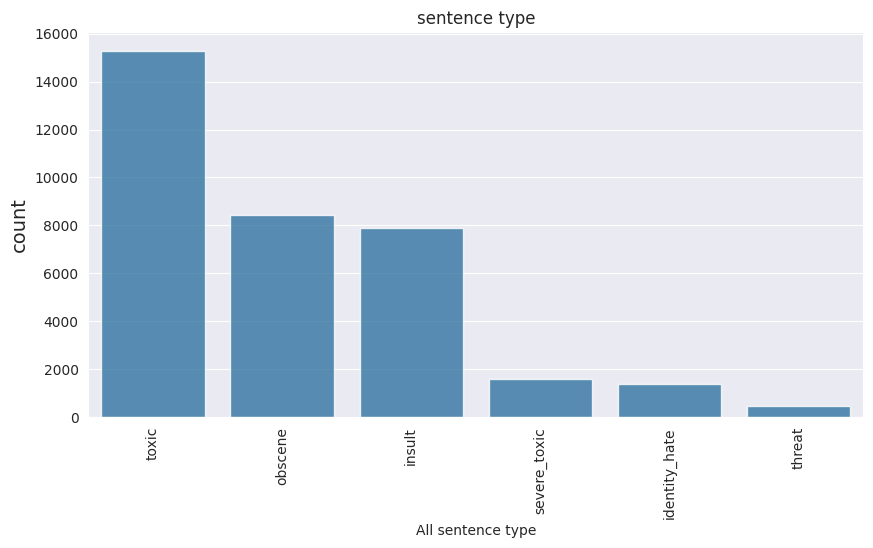

In [29]:
sns.set_style('darkgrid')
ls=sentence_graph.sort_values(ascending=False)
plt.figure(figsize=(10,5))
temp=sns.barplot(x=ls.index, y=ls.values,alpha=0.8)
plt.title('sentence type')
plt.ylabel('count',fontsize=14)
plt.xlabel('All sentence type')
temp.set_xticklabels(rotation=90,labels=ls.index,fontsize=10)
plt.show()

#3. Text Preprocessing

In [30]:
alphanumeric=lambda x: re.sub('\w*\d\w*'," ",x)
punc_lower=lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n=lambda x: re.sub("\n"," ",x)
remove_non_ascii=lambda x: re.sub(r'[^\x00-\x7f]',r' ',x)
df['comment_text']=df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)


In [32]:
insulting_comment_df=df.loc[:, ['id','comment_text','insult']]

In [37]:
identity_hate_comment_df=df.loc[:, ['id','comment_text','identity_hate']]

In [38]:
obscene_comment_df=df.loc[:, ['id','comment_text','obscene']]

In [39]:
threat_comment_df=df.loc[:, ['id','comment_text','threat']]

In [42]:
severe_toxic_comment_df=df.loc[:, ['id','comment_text','severe_toxic']]

In [41]:
toxic_comment_df=df.loc[:, ['id','comment_text','toxic']]

In [43]:
severe_toxic_comment_df

,id,comment_text,severe_toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pr...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [44]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [47]:
def wordcloud(df,label):
  subset=df[df[label]==1]
  text=subset.comment_text.values
  wc=WordCloud(background_color='black',max_words=2000)

  wc.generate(' '.join(text))
  plt.figure(figsize=(10,10))
  plt.subplot(221)
  plt.axis('off')
  plt.title('Words frequency in {}'.format(label),fontsize=20)
  plt.imshow(wc.recolor(colormap='gist_earth',random_state=244),alpha=0.98)
  plt.show()

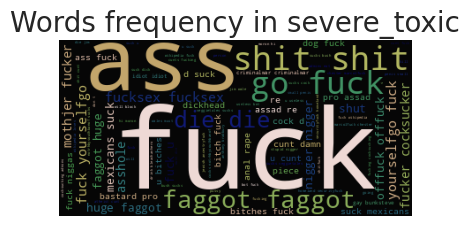

In [49]:
wordcloud(severe_toxic_comment_df,'severe_toxic')

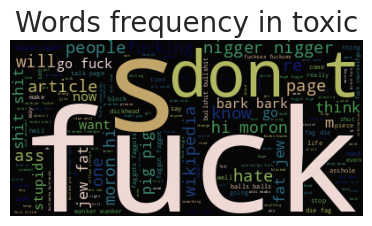

In [51]:
wordcloud(toxic_comment_df,'toxic')

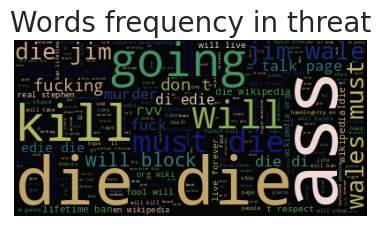

In [52]:
wordcloud(threat_comment_df,'threat')

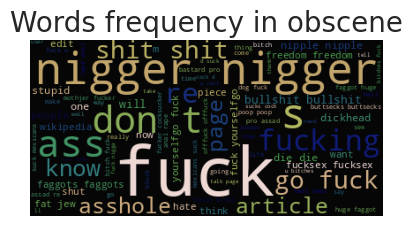

In [53]:
wordcloud(obscene_comment_df,'obscene')

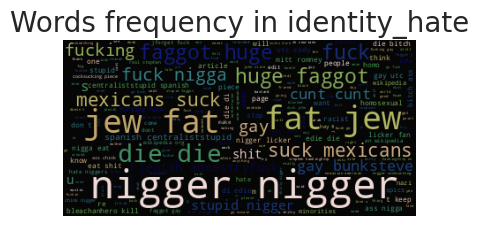

In [54]:
wordcloud(identity_hate_comment_df,'identity_hate')

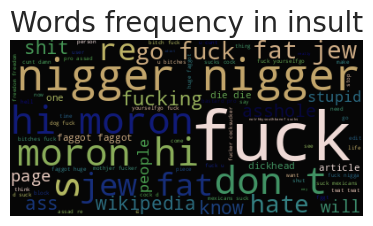

In [55]:
wordcloud(insulting_comment_df,'insult')

#4. Balancing the target column in the DataSet

##1. Toxic Comment

In [66]:
Toxic_comment_balance1=toxic_comment_df[toxic_comment_df['toxic']==1].iloc[0:5000,:]
Toxic_comment_balance0=toxic_comment_df[toxic_comment_df['toxic']==0].iloc[0:5000,:]

In [57]:
Toxic_comment_balance1.shape

(5000, 3)

In [58]:
Toxic_comment_balance0.shape

(5000, 3)

In [67]:
Toxic_comment_balance=pd.concat([Toxic_comment_balance1,Toxic_comment_balance0])

In [68]:
Toxic_comment_balance['toxic'].value_counts()

,count
toxic,
1,5000
0,5000


##2. Severe Toxic Comment

In [69]:
severe_toxic_comment_df['severe_toxic'].value_counts()

,count
severe_toxic,
0,157976
1,1595


In [73]:
severe_toxic_comment_balance1=severe_toxic_comment_df[severe_toxic_comment_df['severe_toxic']==1].iloc[0:1595,:]
severe_toxic_comment_balance0=severe_toxic_comment_df[severe_toxic_comment_df['severe_toxic']==0].iloc[0:1595,:]
severe_toxic_comment_balance=pd.concat([severe_toxic_comment_balance1,severe_toxic_comment_balance0])
severe_toxic_comment_balance['severe_toxic'].value_counts()

,count
severe_toxic,
1,1595
0,1595


##3. Obscence Comment

In [76]:
obscene_comment_df['obscene'].value_counts()

,count
obscene,
0,151122
1,8449


In [81]:
obscene_comment_balance1=obscene_comment_df[obscene_comment_df['obscene']==1].iloc[0:8449,:]
obscene_comment_balance0=obscene_comment_df[obscene_comment_df['obscene']==0].iloc[0:8449,:]
obscene_comment_balance=pd.concat([obscene_comment_balance1,obscene_comment_balance0])
obscene_comment_balance['obscene'].value_counts()

,count
obscene,
1,8449
0,8449


##4. Threat Comment

In [84]:
threat_comment_df['threat'].value_counts()

,count
threat,
0,159093
1,478


In [87]:
threat_comment_balance1=threat_comment_df[threat_comment_df['threat']==1].iloc[0:478,:]
threat_comment_balance0=threat_comment_df[threat_comment_df['threat']==0].iloc[0:478,:]
threat_comment_balance=pd.concat([threat_comment_balance1,threat_comment_balance0])
threat_comment_balance['threat'].value_counts()

,count
threat,
1,478
0,478


##5. Insult Comment

In [88]:
insulting_comment_df['insult'].value_counts()

,count
insult,
0,151694
1,7877


In [90]:
insulting_comment_balance1=insulting_comment_df[insulting_comment_df['insult']==1].iloc[0:7877,:]
insulting_comment_balance0=insulting_comment_df[insulting_comment_df['insult']==0].iloc[0:7877,:]
insulting_comment_balance=pd.concat([insulting_comment_balance1,insulting_comment_balance0])
insulting_comment_balance['insult'].value_counts()

,count
insult,
1,7877
0,7877


##6. Identity Hate Comment

In [89]:
identity_hate_comment_df['identity_hate'].value_counts()

,count
identity_hate,
0,158166
1,1405


In [92]:
identity_hate_comment_balance1=identity_hate_comment_df[identity_hate_comment_df['identity_hate']==1].iloc[0:1405,:]
identity_hate_comment_balance0=identity_hate_comment_df[identity_hate_comment_df['identity_hate']==0].iloc[0:1405,:]
identity_hate_comment_balance=pd.concat([identity_hate_comment_balance1,identity_hate_comment_balance0])
identity_hate_comment_balance['identity_hate'].value_counts()

,count
identity_hate,
1,1405
0,1405


#5. Machine Learning

In [94]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve, fbeta_score, confusion_matrix, roc_auc_score,roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import ngrams,bigrams,trigrams

In [95]:
def cv_tf_train_test(dataframe,label,vectorizer,ngram):

    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]

    # Split our data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Using vectorizer and removing stopwords
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')

    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train)
    X_test_cv1  = cv1.transform(X_test)

    ## Machine learning models

    ## Logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)

    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)

    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)

    ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    ## Random Forest
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)

    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test),
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]}
    ## Saving f1 score results into a dataframe
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])

    return df_f1

#6. Evaluating model performance using evaluation metrics.

In [96]:
severe_toxic_comment_cv = cv_tf_train_test(severe_toxic_comment_balance, 'severe_toxic', TfidfVectorizer, (1,1))
severe_toxic_comment_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
severe_toxic_comment_cv

,F1 Score(severe_toxic)
Log Regression,0.940282
KNN,0.860192
BernoulliNB,0.790738
MultinomialNB,0.932377
SVM,0.937901
Random Forest,0.941176


In [97]:
obscene_comment_cv = cv_tf_train_test(obscene_comment_balance, 'obscene', TfidfVectorizer, (1,1))
obscene_comment_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
obscene_comment_cv

,F1 Score(obscene)
Log Regression,0.916514
KNN,0.260371
BernoulliNB,0.785481
MultinomialNB,0.897783
SVM,0.930288
Random Forest,0.910396


In [98]:
threat_comment_cv = cv_tf_train_test(threat_comment_balance, 'threat', TfidfVectorizer, (1,1))
threat_comment_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
threat_comment_cv

,F1 Score(threat)
Log Regression,0.897338
KNN,0.844156
BernoulliNB,0.745205
MultinomialNB,0.902098
SVM,0.894737
Random Forest,0.923077


In [99]:
insult_comment_cv = cv_tf_train_test(insulting_comment_balance, 'insult', TfidfVectorizer, (1,1))
insult_comment_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
insult_comment_cv

,F1 Score(insult)
Log Regression,0.905841
KNN,0.315499
BernoulliNB,0.790283
MultinomialNB,0.902316
SVM,0.913322
Random Forest,0.894402


In [100]:
identity_hatecomment_cv = cv_tf_train_test(identity_hate_comment_balance, 'identity_hate', TfidfVectorizer, (1,1))
identity_hatecomment_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
identity_hatecomment_cv

,F1 Score(identity_hate)
Log Regression,0.905707
KNN,0.820046
BernoulliNB,0.776699
MultinomialNB,0.903302
SVM,0.896806
Random Forest,0.888087


In [101]:
X = Toxic_comment_balance.comment_text
y = Toxic_comment_balance['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)
X_test_fit = tfv.transform(X_test)
randomforest = RandomForestClassifier(n_estimators=100, random_state=50)

randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1])

In [102]:
comment1 = ['i killed an insect and ate it']
comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]
## As seen below the above comment is 73 percent toxic

array([0.73019444])

In [103]:
comment2 = ['Is this sentence a good one']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]
## As seen below the above comment is 0.08 percent toxic which says the comment is not toxic

array([0.08770635])

In [104]:
comment2 = ['truth will prevail']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]
## The above comment is 46 percent toxic.

array([0.46738997])